In [123]:
# Libraries import for running the code

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt
import cartopy

# data exploration
import xarray as xr

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

This is the repository path:  c:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth
Had to go 0 folder(s) up.


In [124]:
#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

base_network= os.getcwd() +  "/networks/base.nc"
n_base= pypsa.Network(base_network) #network with all components available in the data sources

added_network = os.getcwd() +  "/networks/elec.nc"
n_add = pypsa.Network(added_network) #network with electrical parameters added to components in data sources 

simplified_network = os.getcwd() +  "/networks/elec_s.nc"
n_simple = pypsa.Network(simplified_network) #network with components simplified and spatial parameters (onshore and offshore regions) added  

clustered_network = os.getcwd() + '/networks/elec_s_4.nc'
n_cluster = pypsa.Network(clustered_network) #network simplified based on number of clusters given

prepared_network = os.getcwd() + "/networks/elec_s_4_ec_lcopt_Co2L-1H.nc"
n_prepared = pypsa.Network(prepared_network) #network defined and ready for optimization

solved_network = os.getcwd() + "/results/networks/elec_s_4_ec_lcopt_Co2L-1H.nc" # or: solved_network = r"C:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth\Result_analysis\..........\elec_s_22_ec_lcopt_Co2L-1H.nc"
n_solve = pypsa.Network(solved_network) #optimized network

n = n_solve

c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatibl

C:\Users\Carlos\AppData\Local\Temp\ipykernel_49788\4155262218.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
C:\Users\Carlos\AppData\Local\Temp\ipykernel_49788\4155262218.py:44: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


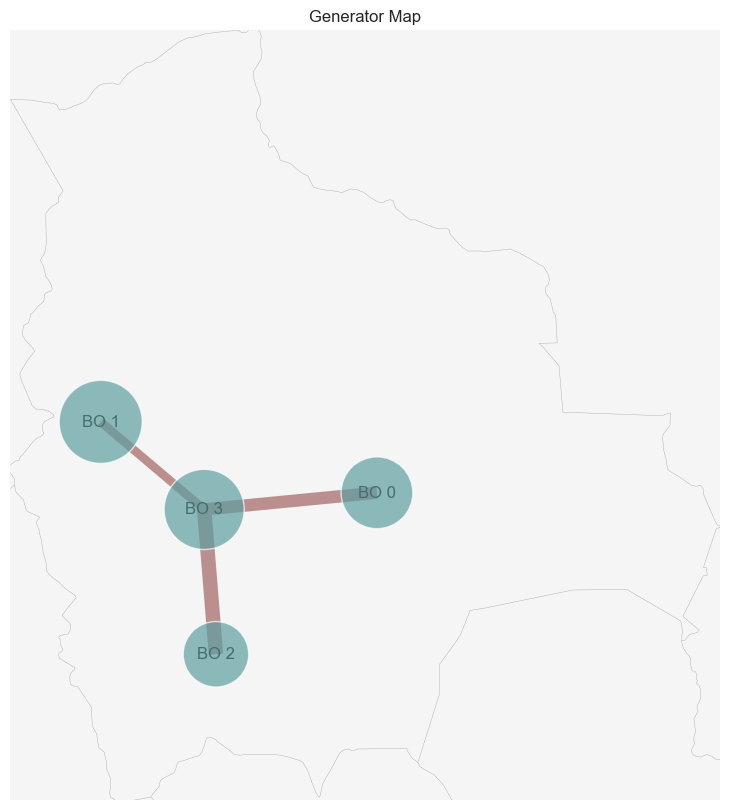

In [125]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n.plot(
    margin=0.1,
    ax=ax,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=0.7,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    )*0.5,  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 1e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

# Convert "Bus" index column to string type
filtered_buses = n.buses
filtered_buses.index = filtered_buses.index.astype(str)
filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
    
# Add bus names to the plot
for bus, (lon, lat) in filtered_buses[['x', 'y']].iterrows():
    ax.text(lon, lat, bus, fontsize=12, color='black', ha='center', va='center')

ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


In [126]:
demand = n.loads_t.p_set.loc["2013-01-01":"2014-01-01"]
demand#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\demands.xlsx")

Load,BO 0,BO 1,BO 2,BO 3
snapshot,,,,
2013-01-01 00:00:00,1132.246721,1517.490744,942.711560,1412.194304
2013-01-01 01:00:00,1012.442986,1356.924098,842.962659,1262.769141
2013-01-01 02:00:00,892.639363,1196.357601,743.213851,1113.344116
2013-01-01 03:00:00,862.324768,1155.728543,717.973841,1075.534248
2013-01-01 04:00:00,362.145994,485.365233,301.523695,451.686457
...,...,...,...,...
2013-12-31 19:00:00,1776.098928,2380.412001,1478.784579,2215.238732
2013-12-31 20:00:00,1419.320440,1902.240554,1181.729884,1770.246894
2013-12-31 21:00:00,1298.488499,1740.295858,1081.124896,1619.539301


In [127]:
reservoir = pd.DataFrame(n.storage_units.p_nom_opt)
reservoir#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\reservoir.xlsx")

,p_nom_opt
StorageUnit,
BO 0 hydro,400.00
BO 1 hydro,66.06
BO 2 hydro,353.46
BO 3 hydro,475.80


In [128]:
generators = pd.DataFrame(n.generators.p_nom_opt)
generators#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\generators.xlsx")

,p_nom_opt
Generator,
BO 0 CCGT,1.236754e+02
BO 0 OCGT,7.839143e-01
BO 0 biomass,6.620100e+02
BO 0 oil,1.116487e+02
BO 0 onwind,1.784615e+03
BO 0 solar,2.575268e+02
BO 1 CCGT,7.093889e+01
BO 1 OCGT,6.268566e+01
BO 1 biomass,8.914398e+02


In [129]:
# Fuel prices:
# gas,fuel,4.44,EUR/MWhth
# biomass,fuel,10.3,EUR/MWhth
# #oil,fuel,124.5,EUR/MWhth

<AxesSubplot:xlabel='snapshot'>

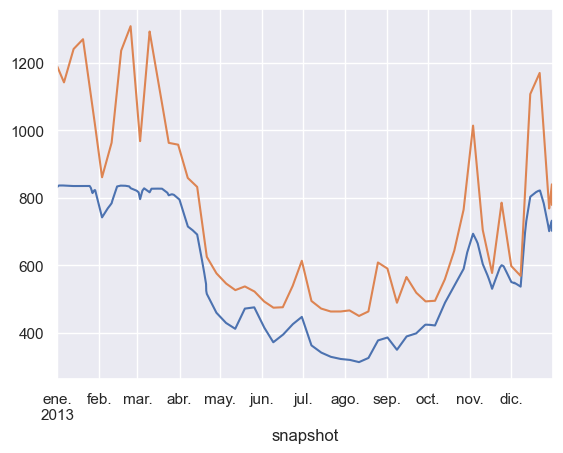

In [130]:
ror_inflow = n.generators_t.p_max_pu.filter(like="ror").mean(axis=1)*n.generators.p_nom_opt.filter(like= "ror").sum()
res_inflow = n.storage_units_t.inflow.filter(like= "hydro").sum(axis=1)*n.storage_units.p_nom_opt.filter(like= "hydro").sum()/1000
res_dispatch = n.storage_units_t.p.filter(like= "hydro").sum(axis=1)
ror_dispatch = n.generators_t.p.filter(like="ror").sum(axis=1)
ror_inflow#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\ror_inflow.xlsx")
res_inflow#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\res_inflow.xlsx")
ror_inflow.plot()
res_inflow.plot()
#res_dispatch.plot()
#ror_dispatch.plot()

In [131]:
spillage = n.storage_units_t.spill
spillage.sum()

StorageUnit
BO 0 hydro    179.481681
BO 1 hydro    133.844769
BO 2 hydro    234.909344
BO 3 hydro    167.495663
dtype: float64

In [132]:
lines = n.lines.loc[:,["bus0","bus1","s_nom_opt"]]
lines#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\lines.xlsx")

,bus0,bus1,s_nom_opt
Line,,,
1,BO 0,BO 3,897.709584
2,BO 1,BO 3,616.574029
3,BO 2,BO 3,1041.256280


In [133]:
stores = n.stores.e_nom_opt
stores#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\storage.xlsx")

Store
BO 0 battery     642.727346
BO 1 battery    2882.431153
BO 2 battery    1092.099696
BO 3 battery    3232.741842
Name: e_nom_opt, dtype: float64

In [134]:
generators_variables = n.generators.drop(columns=["p_nom_max","weight","capital_cost","p_nom_min","marginal_cost","p_nom","p_nom_extendable","control","sign","build_year","p_min_pu","p_max_pu","marginal_cost_quadratic","lifetime","p_set","q_set","type","committable"])
generators_variables = generators_variables[~generators_variables.index.str.contains("load")]
generators_variables#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\variables_generators.xlsx")

,efficiency,carrier,bus,p_nom_opt,min_up_time,min_down_time,up_time_before,down_time_before,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,
BO 0 CCGT,0.4695,CCGT,BO 0,123.675369,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 OCGT,0.3246,OCGT,BO 0,0.783914,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 biomass,0.2966,biomass,BO 0,662.010038,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 oil,0.3690,oil,BO 0,111.648717,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,1.0000,onwind,BO 0,1784.614809,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,1.0000,solar,BO 0,257.526849,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 CCGT,0.4695,CCGT,BO 1,70.938888,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 OCGT,0.3246,OCGT,BO 1,62.685661,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 biomass,0.2966,biomass,BO 1,891.439794,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0


In [135]:
#average capacity factor
capacity_factor = n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).mean()
for i in capacity_factor.index:
    if capacity_factor.loc[i, 'onwind'] > 1: capacity_factor.loc[i, 'onwind'] = 1
    if capacity_factor.loc[i, 'solar'] > 1: capacity_factor.loc[i, 'solar'] = 1 

capacity_factor['onwind']#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\capacity_factor_wind.xlsx")
capacity_factor['solar']#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\capacity_factor_solar.xlsx")
capacity_factor['onwind'].mean()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_49788\1692402589.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  capacity_factor = n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).mean()


0.22773065564187478

In [136]:
cols = "onwind"
generation = n.generators_t.p.loc["2013-01-01":"2014-01-01"].filter(regex=cols)
real_CP= generation.sum().sum()/(n.generators.p_nom_opt.filter(like=cols).sum()*8760)
real_CP

0.2716778932817761

In [137]:
cols = "onwind"
potential_gen = n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].filter(regex=cols) * n.generators.loc[[idx for idx in n.generators.index if cols in idx]]['p_nom_opt']
max_CP= potential_gen.sum().sum()/(n.generators.p_nom_opt.filter(like=cols).sum()*8760)
max_CP

0.3357334158882903

In [143]:
potential_gen.max()

Generator
BO 0 onwind    4039.103907
BO 1 onwind       0.323492
BO 2 onwind    1498.539627
BO 3 onwind       0.547000
dtype: float64

In [141]:
n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].filter(regex=cols).mean()

Generator
BO 0 onwind    0.362567
BO 1 onwind    0.124509
BO 2 onwind    0.274687
BO 3 onwind    0.155304
dtype: float64